In [98]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
cd workspace/theislab/mubind/notebooks/batch

/mnt/c/Users/ignacio.ibarra/Dropbox/workspace/theislab/mubind/notebooks/batch


In [99]:
import mubind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = '../../annotations'
# mb.models.MultiBind
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import logomaker

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

Using device: cuda:0


In [100]:
import os

train_as_list = False

df = []
basedir = '../../../mubind-pipeline/output/snakemake/SELEX'
batch = 0
for tf in os.listdir(basedir):
    for f in os.listdir(os.path.join(basedir, tf)):
        if f.endswith('.tsv.gz'):
            df2 = pd.read_csv(os.path.join(basedir, tf, f), sep='\t', index_col=0) # head(10)
            print(f)
            assert 'batch' in df2
            # print(df2.columns)
            n_rounds = len(df2.columns) - 2
            df2.columns =  list(range(n_rounds)) + ['batch', 'is_count_data']
            df2['batch'] = batch
            df2['n_rounds'] = n_rounds
            batch += 1
            df.append(df2)
            # assert False

if not train_as_list:
    # concatenation/reordering
    df = pd.concat(df)
    df = df[[c for c in df.columns if not c in ['batch', 'is_count_data', 'n_rounds']] + ['batch', 'is_count_data', 'n_rounds']]

ALX1-ZeroCycle_TACCAA40NTTA_0_0-TACCAA40NTTA.tsv.gz
ALX1-ZeroCycle_TCCTTG40NGGT_0_0-TCCTTG40NGGT.tsv.gz
ALX4-ZeroCycle_ES0_TGTGTC20NGA_0-TGTGTC20NGA.tsv.gz
ALX4-ZeroCycle_TCTATT40NCAT_0_0-TCTATT40NCAT.tsv.gz
ALX4-ZeroCycle_TGCGTA40NTCA_0_0-TGCGTA40NTCA.tsv.gz
ALX4-ZeroCycle_TGTGTC20NGA_0_0-TGTGTC20NGA.tsv.gz
CTCF-ZeroCycle_ES0_TAGCGA20NGCT_0-TAGCGA20NGCT.tsv.gz
CTCF-ZeroCycle_TAGCGA20NGCT_0_0-TAGCGA20NGCT.tsv.gz
EGR1-ZeroCycle_ES0_TACTAT20NATC_0-TACTAT20NATC.tsv.gz
EGR1-ZeroCycle_ES0_TCTCTT20NGA_0-TCTCTT20NGA.tsv.gz
EGR1-ZeroCycle_TACTAT20NATC_0_0-TACTAT20NATC.tsv.gz
EGR1-ZeroCycle_TAGACA40NGTC_0_0-TAGACA40NGTC.tsv.gz
EGR1-ZeroCycle_TCAGCC40NTTC_0_0-TCAGCC40NTTC.tsv.gz
EGR1-ZeroCycle_TCCGCT40NGCG_0_0-TCCGCT40NGCG.tsv.gz
EGR1-ZeroCycle_TCTCTT20NGA_0_0-TCTCTT20NGA.tsv.gz
EGR1-ZeroCycle_TTGTAC40NGTA_0_0-TTGTAC40NGTA.tsv.gz
ELF2-ZeroCycle_TAGGAG40NAGT_0_0-TAGGAG40NAGT.tsv.gz
ELF2-ZeroCycle_TGAAAT40NCAA_0_0-TGAAAT40NCAA.tsv.gz
ELF2-ZeroCycle_TGCTTC40NTTA_0_0-TGCTTC40NTTA.tsv.gz
ELF2-ZeroCyc

In [101]:
sparsify = True
if sparsify:
    print(df.memory_usage())
    mem_before = df.memory_usage().sum()
    for c in df.columns[:-3]:
        # print(c)
        df[c] = pd.arrays.SparseArray(df[c])
    print('after sparse')
    print(df.memory_usage())
    mem_after = df.memory_usage().sum()
    print(mem_before, mem_after, mem_after / mem_before)

Index            8760000
0                8760000
1                8760000
2                8760000
3                8760000
4                8760000
5                8760000
6                8760000
batch            8760000
is_count_data    8760000
n_rounds         8760000
dtype: int64
after sparse
Index             8760000
0                 2622876
1                 3081804
2                 2793888
3                 2916156
4                12780000
5                  540000
6                  540000
batch             8760000
is_count_data     8760000
n_rounds          8760000
dtype: int64
96360000 60314724 0.6259311332503114


In [73]:
train = []
if isinstance(df, list):
    train = []
    for df2 in df:
        dataset = mb.datasets.SelexDataset(df2, n_rounds=df2['n_rounds'], labels=list(df2.columns[:-3]), use_sparse=True)
        next_train = tdata.DataLoader(dataset=dataset,
                                 # batch_size=256,
                                 batch_size=512,
                                 shuffle=False)
        train.append(next_train)
else:
    dataset = mb.datasets.SelexDataset(df, n_rounds=df['n_rounds'], labels=list(df.columns[:-3]), use_sparse=True)
    train = tdata.DataLoader(dataset=dataset,
                             # batch_size=256,
                             batch_size=512,
                             shuffle=False)


In [74]:
import warnings
warnings.filterwarnings('ignore')

In [75]:
import numpy as np

In [76]:
%load_ext line_profiler


The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [97]:
# assign batch and data type

# data['batch'] = 0
# data['is_count_data'] = 1
# n_batches=3

dirichlet_regularization = 0
# for dirichlet_regularization_log in range(-5, 3):

n_epochs = 100
log_each = 1
n_kernels = 4
lr = [0.01] * n_kernels
wd = [0.01,] + [0.001] * (n_kernels - 1)
early_stopping = [5,] + [25] * (n_kernels - 1)
w = 15 # min(len(motif), 6)
opt_kernel_shift = 1
opt_kernel_length = 1

from matplotlib import rcParams
rcParams['figure.figsize'] = 8, 1

import time
t0 = time.time()

criterion = mb.tl.PoissonLoss()

for ignore_kernel in [1]: # [0, 1]:
    print('\n\n##NEW JOB')
    print('ignore kernel', ignore_kernel)
    model_by_k, res_next = mb.tl.optimize_iterative(train, device, w=w, show_logo=0, criterion=criterion,
                                                 opt_kernel_shift=opt_kernel_shift, opt_kernel_length=opt_kernel_length,
                                                 dirichlet_regularization=dirichlet_regularization, # 10 ** dirichlet_regularization_log,
                                                 lr=wd, weight_decay=wd, ignore_kernel=ignore_kernel, use_mono=True,
                                                 num_epochs=n_epochs, early_stopping=early_stopping, use_dinuc=True, # optimiser=torch.optim.LBFGS,
                                                 n_kernels=n_kernels, log_each=log_each, stop_at_kernel=None) #  seed=seed) # seeds.index[0]) #
    print('##DONE....\n\n')


print('total time: %.3f s' % ((time.time() - t0)))
# res = []
# model_by_k = {}

model = model_by_k





##NEW JOB
ignore kernel 1
next w 15 <class 'int'>
# rounds {4, 5, 6, 7, 9}
# batches 87
# kernels 4
# initial w 15
# enr_series True

Kernel to optimize 0

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel mono at 0 to 1
setting grad status of kernel dinuc at 0 to 0
setting grad status of kernel mono at 1 to 0
setting grad status of kernel dinuc at 1 to 0
setting grad status of kernel mono at 2 to 0
setting grad status of kernel dinuc at 2 to 0
setting grad status of kernel mono at 3 to 0
setting grad status of kernel dinuc at 3 to 0


kernels mask [0 1 1 1]
optimizing using <class 'torch.optim.adam.Adam'> and <class 'mubind.tl.loss.PoissonLoss'> n_epochs 100 early_stopping 5
lr= 0.01, weight_decay= 0.01, dir weight= 0
Epoch:  2, Loss: 7.336112 , best epoch: 0 secs per epoch: 18.295 s
Epoch:  3, Loss: 7.322048 , best epoch: 1 secs per epoch: 12.658 s
Epoch:  4, Loss: 7.315483 , best epoch: 2 secs per epoch: 10.845 s
Epoch:  5, Loss: 7.312136 , best epoch: 3 

KeyboardInterrupt: 

### We can visualize the overall results obtained by the network, once the training is finished

In [113]:
# %load_ext line_profiler
# %lprun -f mb.tl.optimize_simple mb.tl.optimize_iterative(train, device, w=w, show_logo=0, criterion=criterion, opt_kernel_shift=0, opt_kernel_length=0, dirichlet_regularization=dirichlet_regularization, lr=lr, weight_decay=wd, ignore_kernel=ignore_kernel, num_epochs=n_epochs, early_stopping=early_stopping, use_dinuc=False, n_kernels=n_kernels, log_each=log_each, stop_at_kernel=None) #  seed=seed) # seeds.index[0]) #


In [114]:
import mubind as mb

In [95]:
model = model_by_k
mb.tl.scores(model, train)


NameError: name 'model_by_k' is not defined

In [94]:
train

In [92]:
counts = mb.tl.predict(model, train)
counts

NameError: name 'model' is not defined

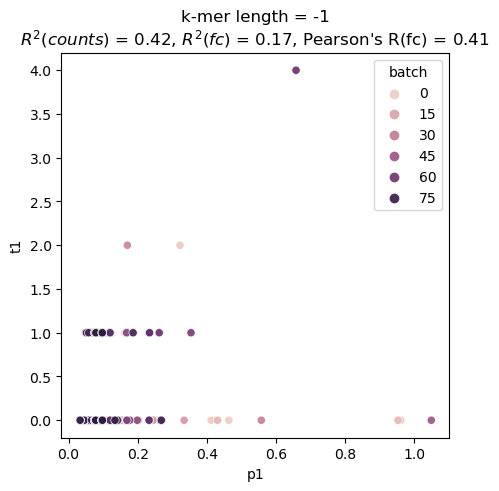

{'r2_counts': 0.41630760884794105,
 'r2_foldchange': 0.09279180683415378,
 'r2_enr': 0.18690996772432344,
 'r2_fc': 0.16716222547542411,
 'pearson_foldchange': 0.4088547730862685}

In [117]:
rcParams['figure.figsize'] = 5, 5
mb.pl.kmer_enrichment(model, train, log_scale=False, style='scatter', ylab='t1', xlab='p1')


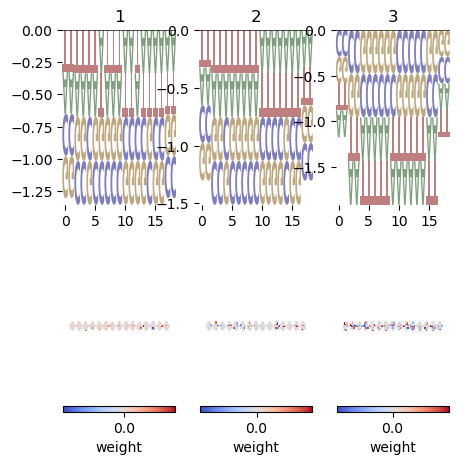

In [118]:
mb.pl.conv(model)
